<a href="https://colab.research.google.com/github/Ganeshkumar-1358/batch-20_1358/blob/main/pds_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
def predict_crop_with_reason(temp, hum, ph, rain, soil_type, reason_template=None):
    # 🔎 Step 1: Exact Match
    match = df[
        (df['temperature'] == temp) &
        (df['humidity'] == hum) &
        (df['ph'] == ph) &
        (df['rainfall'] == rain) &
        (df['Soil_Type'] == soil_type)
    ]

    if match.empty:
        # 🔎 Step 2: Nearest Match Search
        df_soil = df[df['Soil_Type'] == soil_type]

        if df_soil.empty:
            print("❌ No values found in dataset (Soil type mismatch)")
            return None

        # Calculate distance from given values
        df_soil["distance"] = np.sqrt(
            (df_soil["temperature"] - temp) ** 2 +
            (df_soil["humidity"] - hum) ** 2 +
            (df_soil["ph"] - ph) ** 2 +
            (df_soil["rainfall"] - rain) ** 2
        )

        nearest = df_soil.sort_values("distance").head(1)

        if nearest.empty or nearest["distance"].values[0] > 10:  # threshold (tunable)
            print("❌ No Crop is Grown for Climate Conditions")
            return None

        # Use nearest row values
        temp = nearest["temperature"].values[0]
        hum = nearest["humidity"].values[0]
        ph = nearest["ph"].values[0]
        rain = nearest["rainfall"].values[0]
        soil_type = nearest["Soil_Type"].values[0]

        print(f"⚠️ Exact values not found, using nearest values from dataset: "
              f"T={temp}, H={hum}, pH={ph}, Rain={rain}, Soil={soil_type}")

    # ✅ Step 3: Proceed with Prediction
    soil_encoded = soil_encoder.transform([soil_type])[0]
    features = pd.DataFrame(
        [[temp, hum, ph, rain, soil_encoded]],
        columns=['temperature', 'humidity', 'ph', 'rainfall', 'Soil_Type']
    )

    probs = rf.predict_proba(features)[0]
    crops = crop_encoder.inverse_transform(range(len(probs)))
    best_crop = crops[np.argmax(probs)]

    # Plot probabilities
    plt.figure(figsize=(10,5))
    sns.barplot(x=crops, y=probs, palette="viridis")
    plt.xticks(rotation=45)
    plt.title(f"Crop Prediction Probabilities (Predicted: {best_crop})")
    plt.ylabel("Probability")
    plt.xlabel("Crop")
    plt.show()

    # Default reason
    if reason_template is None:
        reason_template = (
            "📌 Reason: Best/Nearest match -> Temperature={temp}°C, "
            "Humidity={hum}%, pH={ph}, Rainfall={rain} mm, Soil={soil}"
        )

    reason_text = reason_template.format(
        temp=temp, hum=hum, ph=ph, rain=rain, soil=soil_type
    )

    print(f"🌱 Predicted Crop: {best_crop}")
    print(reason_text)

    return best_crop
predict_crop_with_reason(3, 90,5, 109, "Sandy")


❌ No Crop is Grown for Climate Conditions


/tmp/ipython-input-2806324212.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil["distance"] = np.sqrt(


In [65]:
from sklearn.metrics import accuracy_score

# ✅ Check accuracy on test dataset
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🎯 Model Accuracy on Test Data: {acc*100:.2f}%")


🎯 Model Accuracy on Test Data: 95.68%


✅ Dataset loaded with shape: (2200, 7)
   temperature   humidity        ph    rainfall label  Label_Num Soil_Type
0    20.879744  82.002744  6.502985  202.935536  rice          0     Silty
1    21.770462  80.319644  7.038096  226.655537  rice          0     Peaty
2    23.004459  82.320763  7.840207  263.964248  rice          0     Loamy
3    26.491096  80.158363  6.980401  242.864034  rice          0     Peaty
4    20.130175  81.604873  7.628473  262.717340  rice          0     Peaty
✅ RandomForest model trained successfully!
🎯 Model Accuracy on Test Set: 95.68%
⚠️ Exact values not found, using nearest values from dataset: T=21.97199397, H=81.89918197, pH=5.658169482, Rain=227.3637009, Soil=Sandy


/tmp/ipython-input-3894452097.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crops, y=probs, palette="viridis")


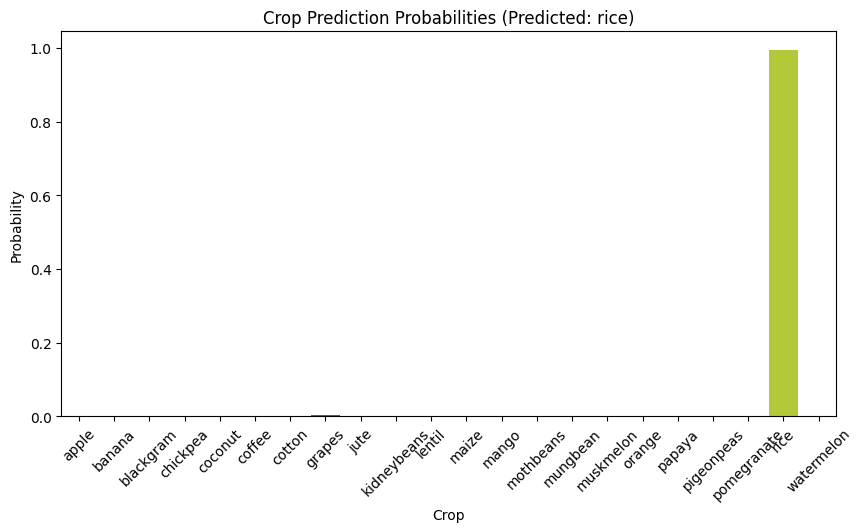

🌱 Predicted Crop: rice
📌 Reason: Best/Nearest match -> Temperature=21.97199397°C, Humidity=81.89918197%, pH=5.658169482, Rainfall=227.3637009 mm, Soil=Sandy


'rice'

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# -------------------------------
# STEP 1: Load Dataset
# -------------------------------
df = pd.read_csv("Crop_Data_With_Soil.csv")
print("✅ Dataset loaded with shape:", df.shape)
print(df.head())

# Features & Target
X = df[['temperature', 'humidity', 'ph', 'rainfall', 'Soil_Type']].copy()
y = df['label']

# Encode categorical soil type
soil_encoder = LabelEncoder()
X.loc[:, 'Soil_Type'] = soil_encoder.fit_transform(X['Soil_Type'])

# Encode crop labels
crop_encoder = LabelEncoder()
y_encoded = crop_encoder.fit_transform(y)

# -------------------------------
# STEP 2: Train Model + Accuracy
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

print("✅ RandomForest model trained successfully!")

# ✅ Calculate Accuracy
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy on Test Set: {acc*100:.2f}%")

# -------------------------------
# STEP 3: Prediction Function
# -------------------------------
def predict_crop_with_reason(temp, hum, ph, rain, soil_type, reason_template=None):
    # 🔎 Step 1: Exact Match
    match = df[
        (df['temperature'] == temp) &
        (df['humidity'] == hum) &
        (df['ph'] == ph) &
        (df['rainfall'] == rain) &
        (df['Soil_Type'] == soil_type)
    ]

    if match.empty:
        # 🔎 Step 2: Nearest Match Search
        df_soil = df[df['Soil_Type'] == soil_type]

        if df_soil.empty:
            print("❌ No values found in dataset (Soil type mismatch)")
            return None

        # Calculate distance from given values
        df_soil = df_soil.copy()
        df_soil["distance"] = np.sqrt(
            (df_soil["temperature"] - temp) ** 2 +
            (df_soil["humidity"] - hum) ** 2 +
            (df_soil["ph"] - ph) ** 2 +
            (df_soil["rainfall"] - rain) ** 2
        )

        nearest = df_soil.sort_values("distance").head(1)

        if nearest.empty or nearest["distance"].values[0] > 10:
            print("❌ No Crop is Grown for Climate Conditions")
            return None

        # Use nearest row values
        temp = nearest["temperature"].values[0]
        hum = nearest["humidity"].values[0]
        ph = nearest["ph"].values[0]
        rain = nearest["rainfall"].values[0]
        soil_type = nearest["Soil_Type"].values[0]

        print(f"⚠️ Exact values not found, using nearest values from dataset: "
              f"T={temp}, H={hum}, pH={ph}, Rain={rain}, Soil={soil_type}")

    # ✅ Step 3: Proceed with Prediction
    soil_encoded = soil_encoder.transform([soil_type])[0]
    features = pd.DataFrame(
        [[temp, hum, ph, rain, soil_encoded]],
        columns=['temperature', 'humidity', 'ph', 'rainfall', 'Soil_Type']
    )

    probs = rf.predict_proba(features)[0]
    crops = crop_encoder.inverse_transform(range(len(probs)))
    best_crop = crops[np.argmax(probs)]

    # Plot probabilities
    plt.figure(figsize=(10,5))
    sns.barplot(x=crops, y=probs, palette="viridis")
    plt.xticks(rotation=45)
    plt.title(f"Crop Prediction Probabilities (Predicted: {best_crop})")
    plt.ylabel("Probability")
    plt.xlabel("Crop")
    plt.show()

    # Default reason
    if reason_template is None:
        reason_template = (
            "📌 Reason: Best/Nearest match -> Temperature={temp}°C, "
            "Humidity={hum}%, pH={ph}, Rainfall={rain} mm, Soil={soil}"
        )

    reason_text = reason_template.format(
        temp=temp, hum=hum, ph=ph, rain=rain, soil=soil_type
    )

    print(f"🌱 Predicted Crop: {best_crop}")
    print(reason_text)

    return best_crop

# -------------------------------
# STEP 4: Example Run
# -------------------------------
predict_crop_with_reason(
    temp=25, hum=82, ph=5.5, rain=220, soil_type="Sandy"
)
